# Different thermal models of the cooling oceanic lithosphere
In computing the yield strength, we noted the importance of temperature. He're we'll look more closely at a few different ways to model cooling as new oceanic crust is created and moves away from the mid-ocean ridge.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import math

In [2]:
# spreading rate, m/yr
rate = 0.02

In [3]:
# run the C program and output to out.temp
def run_thermal_model(model,rate):
    if model == 1:
        model_name = 'sleep_modified '
        runcmd = model_name + str(rate) + ' 0'
    elif model == 2:
        model_name = 'sleep_modified '
        runcmd = model_name + str(rate) + ' 1'
    else:
        model_name = 'sleep_cooling '
        runcmd = model_name + str(rate)
    outfile = open("out.temp","w")
    print(runcmd)
    subprocess.call(runcmd,stdout=outfile,shell=True)

In [4]:
# read data into numpy array
def read_thermal_model(outfile):
    data = np.loadtxt(fname=outfile)
    # extract top row and first columns (x and z coords)
    x_coords = data[0,1:] / 1000;
    z_coords = data[1:,0] / -1000;
    temps = np.transpose(data[1:,1:])
    return x_coords,z_coords,temps

In [22]:
# simple plotting of thermal models
def plot_thermal_profiles(x,z,t):
    plt.plot(t[:,3],z,label='near axis')
    plt.plot(t[:,149],z,label='X = 15 km')
    plt.plot(t[:,299],z,label='X = 30 km')
    plt.xlim(0, 1500)
    plt.ylim(-30,0)
    plt.xlabel('Temperature (C)')
    plt.ylabel('Depth (km)')
    plt.legend()
    plt.show()

In [23]:
def plot_thermal_contours(x,z,t):
    # make mesh
    X,Z = np.meshgrid(x,z)
    TC = plt.contour(X,Z,t,colors='k',levels=[0, 300, 600, 800, 1000, 1185])
    plt.clabel(TC,fmt="%.0f")
    plt.show()

## Half space cooling and plate cooling
The temperature of the material is of great importance in evaluating the yield strength. Since we're concerned with young oceanic lithosphere, we need a model for the cooling of the material. Probably the simplest model would be a half space cooling model, and it's simple enough that we will code it up in python.

In [12]:
def hs_cooling(x,z,spr_rate,T_0=0,T_1=1250,z_L=1e5,kappa=8e-7):
    t = (x / spr_rate)*365.25*24*60*60
    T = T_0 + (T_1 - T_0)*math.erf(z/(2*math.sqrt(kappa*t)))
    return T

In [19]:
def plate_cooling(x,z,spr_rate,T_0=0,T_1=1250,z_L=1e5,kappa=8e-7):
    t = (x / spr_rate)*365.25*24*60*60
    T = 0
    p = 0
    for j in range(250):
        n = j+1
        p1 = math.exp(-1*kappa*n*n*math.pi*math.pi*t/z_L/z_L)
        p2 = (1/n)*math.sin(n*math.pi*z/z_L)
        p = p1*p2 + p
        
    T = T_0 + (T_1 - T_0)*((z/z_L) + (2/math.pi)*p)
    return T

In [20]:
z_L = 100000
z = np.linspace(1,30000,300)
x = np.linspace(1,30000,300)
T_0 = 0
T_1 = 1250
T_hs = np.zeros((300,300))
T_pl8 = np.zeros((300,300))
i = 0
for z_i in z:
    j = 0
    for x_i in x:
        T_hs[i,j] = hs_cooling(x_i,z_i,rate,T_0,T_1,z_L)
        T_pl8[i,j] = plate_cooling(x_i,z_i,rate,T_0,T_1,z_L)        
        j += 1
    i += 1
    

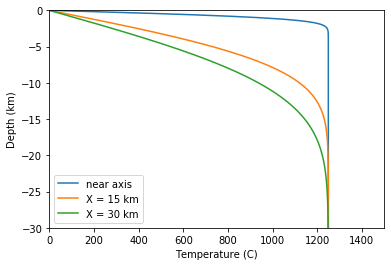

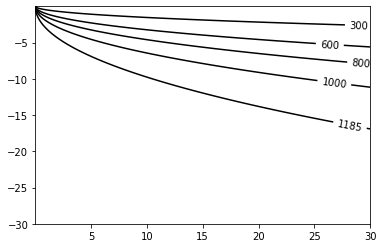

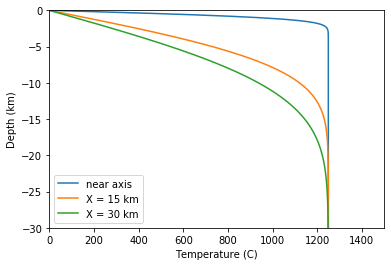

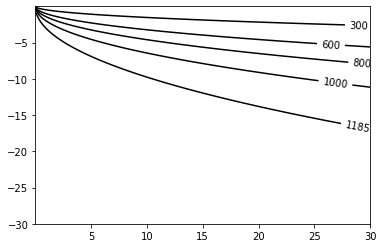

In [24]:
plot_thermal_profiles(x/1000,z/-1000,T_hs)
plot_thermal_contours(x/1000,z/-1000,T_hs)
plot_thermal_profiles(x/1000,z/-1000,T_pl8)
plot_thermal_contours(x/1000,z/-1000,T_pl8)


## Sleep (1975)

In [25]:
run_thermal_model(1,rate)

sleep_modified 0.02 0


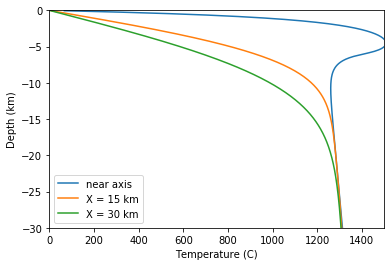

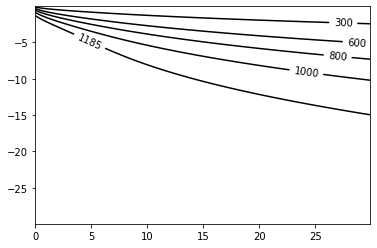

In [26]:
x_coords, z_coords, T_sleep = read_thermal_model('out.temp')
plot_thermal_profiles(x_coords,z_coords,temps)
plot_thermal_contours(x_coords,z_coords,temps)

## Morton and Sleep (1985)

In [27]:
run_thermal_model(2,rate)

sleep_modified 0.02 1


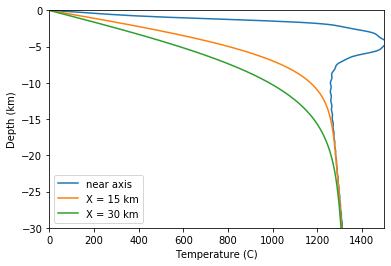

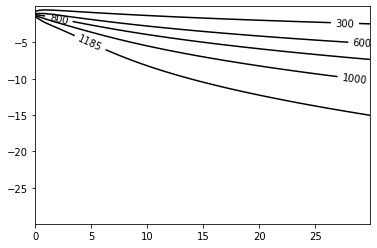

In [28]:
x_coords, z_coords, T_sinks = read_thermal_model('out.temp')
plot_thermal_profiles(x_coords,z_coords,temps)
plot_thermal_contours(x_coords,z_coords,temps)

The major difference between the Sleep and M&S models is near the axis, where the heat sinks are depressing the isotherms slightly. The ad hoc heat sink distribution has a few constraints. Firstly, The temperature should not be anywhere less than the surface temperature. Secondly, we keep sinks above the 600 C isotherm.